**Fronteiras Teóricas e mapa de regimes**

# Fig. 1 - Toeria (fronteiras) e mapa de regimes ($\mu$ x $ϵ$)

Objetivo: Reproduzir geometria teórica das fronteiras de **sincronização** e **escape** no plano ($\mu$, $ϵ$)

## Imports, utilidades e paths

In [2]:
## Imports, utilidades e paths

import os, json, math, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Paths de saída
FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(exist_ok=True, parents=True); DATA.mkdir(exist_ok=True, parents=True)

# Utilidades teóricas

def eps_sync_bounds(mu: float):
  mu = float(mu)
  if abs(mu) < 1e-12:
    return (np.nan, np.nan)
  inv = 1.0/abs(mu)
  return (1.0 - inv, 1.0 + inv)


def eps_escape_bounds(mu: float):
  mu = float(mu)
  if abs(mu) < 1e-12:
    return (np.nan, np.nan)
  e1 = 1.0 - 3.0/mu
  e2 = 1.0 + 3.0/mu
  return (min(e1,e2), max(e1,e2))

## Contruindo mapa teórico (gráfico)

Figura salva em: figs\FIG1_teoria_mu_eps.png


100390

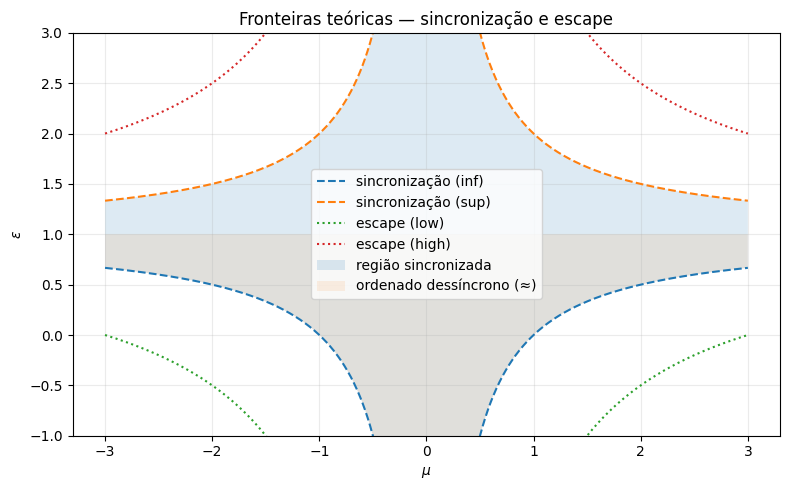

In [3]:
# Grade de parâmetros (positivo) — espelha para μ<0 se quiser
mu_grid = np.linspace(-3, 3, 1000)

# Curvas
sync_inf = np.array([eps_sync_bounds(mu)[0] for mu in mu_grid])
sync_sup = np.array([eps_sync_bounds(mu)[1] for mu in mu_grid])
esc_lo   = np.array([eps_escape_bounds(mu)[0] for mu in mu_grid])
esc_hi   = np.array([eps_escape_bounds(mu)[1] for mu in mu_grid])

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(mu_grid, sync_inf, linestyle='--', label='sincronização (inf)')
ax.plot(mu_grid, sync_sup, linestyle='--', label='sincronização (sup)')
ax.plot(mu_grid, esc_lo, linestyle=':', label='escape (low)')
ax.plot(mu_grid, esc_hi, linestyle=':', label='escape (high)')

# Sombreamentos qualitativos
# Região sincronizada: entre as linhas de sync (inf) e (sup)
ax.fill_between(mu_grid, sync_inf, sync_sup, alpha=0.15, label='região sincronizada')

# Opcional: área "ordenado dessíncrono" (ε entre sync_inf e 1)
ax.fill_between(mu_grid, sync_inf, 1.0, where=(sync_inf<1.0), alpha=0.10, label='ordenado dessíncrono (≈)')

ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Fronteiras teóricas — sincronização e escape")
ax.grid(alpha=0.25)
ax.set_ylim(-1, 3)
ax.legend(loc='best', frameon=True)
plt.show

out = FIGS/"FIG1_teoria_mu_eps.png"
fig.tight_layout(); fig.savefig(out, dpi=200); #plt.close(fig)
print("Figura salva em:", out)

# Salva dicionário com arrays
payload = {
    "mu_grid": mu_grid.tolist(),
    "sync_inf": sync_inf.tolist(),
    "sync_sup": sync_sup.tolist(),
    "esc_lo": esc_lo.tolist(),
    "esc_hi": esc_hi.tolist(),
}
(DATA/"theory_bounds_mu_eps.json").write_text(json.dumps(payload), encoding='utf-8')